In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

image_file = 'test_images/test6.jpg'

In [2]:
window_width = 64 # 
window_height = 120 #180 con el primer src, 120
margin = 40 #40 con el primer src, 60

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension    

src = np.float32(
    [[0, 720],
    [1280, 720],
    [510, 480],
    [770, 480]])

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])

m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)

with open('calibration_data/calibration_matrices.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']

In [3]:
def abs_sobel_thres(img, orient='x', sobel_thresh=(20, 100)):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thres(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thres(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

def HLS_thres(img, HLS_thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > HLS_thresh[0]) & (s_channel <= HLS_thresh[1])] = 1
    return binary_output

def HSV_thres(img, HSV_thresh=(100, 255)):
    """
    Convert RGB to HSV and threshold to binary image using V channel
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > HSV_thresh[0]) & (v_channel <= HSV_thresh[1])] = 1
    return binary_output

def yellow(img):
    """
    Convert RGB to HSV and threshold to binary image using Only Yellow Colors
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([0,50,100])
    upper_yellow = np.array([50,255,255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask/255
    return mask

def white(img):
    """
    Convert RGB to HSV and threshold to binary image using Only White Colors
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = np.array([14,0,170])
    upper_white = np.array([255,80,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    mask = mask/255
    return mask

def combined_thresh(img):
    """
    Combined threshold - Abs | (Mag & Dir) | (HLS & HSV)
    """
    abs_bin = abs_sobel_thres(img, orient='x', sobel_thresh=(30, 255))#50
    mag_bin = mag_thres(img, sobel_kernel=3, mag_thresh=(50, 255))#60
    dir_bin = dir_thres(img, sobel_kernel=15, dir_thresh=(0.7, 1.1))
    hls_bin = HLS_thres(img, HLS_thresh=(100, 255))#150
    hsv_bin = HSV_thres(img, HSV_thresh=(100, 255))#220
    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1))] = 1

    return combined

def combined_thresh2(img):
    """
    Combined threshold - Abs | (Mag & Dir) | (HLS & HSV) | (Yellow | White)
    """
    abs_bin = abs_sobel_thres(img, orient='x', sobel_thresh=(60, 255))
    mag_bin = mag_thres(img, sobel_kernel=3, mag_thresh=(60, 255))
    dir_bin = dir_thres(img, sobel_kernel=15, dir_thresh=(0.7, 1.1))
    hls_bin = HLS_thres(img, HLS_thresh=(11, 255))
    hsv_bin = HSV_thres(img, HSV_thresh=(170, 255))
    yellow_bin = yellow(img)
    white_bin= white(img)
    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1)) | ((yellow_bin == 1)|(white_bin == 1))] = 1
    
    return combined


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def window_search(warped,window_centroids):
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    left_mask = np.concatenate((np.ones((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)*255, np.zeros((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)), axis=1)
    right_mask = np.concatenate((np.zeros((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8), np.ones((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)*255), axis=1)
    left = cv2.bitwise_and(left_mask,output)
    right = cv2.bitwise_and(right_mask,output)
    return left,right,template

def curvature(left_points,right_points):
    left_fit_cr = np.polyfit(left_points[:,1]*ym_per_pix, left_points[:,0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_points[:,1]*ym_per_pix, right_points[:,0]*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*719*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*719*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad
    

last_points = np.zeros((1,720*2,2), dtype=np.int32)
t = 0

def pipeline(image):
    global last_points
    global t
    t=t+1
    image = cv2.undistort(image, mtx, dist, None, mtx)
    binary = combined_thresh(image)
    warped = cv2.warpPerspective(binary, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warped[:,0:150] = 0
    warped[300:720,500:1000] = 0
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    left,right,template = window_search(warped,window_centroids)
    left_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(left, cv2.COLOR_BGR2GRAY))))
    right_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(right, cv2.COLOR_BGR2GRAY))))
    l_fit = np.polyfit(left_points[:,0],left_points[:,1],2)
    r_fit = np.polyfit(right_points[:,0],right_points[:,1],2)
    the_points = np.zeros((1,720*2,2), dtype=np.int32)
    for i in range(0,720):
        the_points[0][i] = [int(l_fit[0]*i*i + l_fit[1]*i + l_fit[2]),i]
    for i in range(0,720):
        the_points[0][i+720] = [int(r_fit[0]*(719-i)*(719-i) + r_fit[1]*(719-i) + r_fit[2]),(719-i)]
    if(t>1):
        dist_lb = np.linalg.norm(the_points[0][719]-last_points[0][719])
        dist_rb = np.linalg.norm(the_points[0][720]-last_points[0][720])
        dist_lt = np.linalg.norm(the_points[0][0]-last_points[0][0])
        dist_rt = np.linalg.norm(the_points[0][2*720-1]-last_points[0][2*720-1])
        #if((dist_lb>50)or(dist_rb>50)or(dist_lt>50)or(dist_rt>50)):
        if((dist_lb>50)or(dist_rb>50)):
            the_points = last_points
    output_pol = np.zeros_like(template)
    cv2.fillConvexPoly(output_pol,the_points, (0,255,0))
    left_curverad, right_curverad = curvature(left_points,right_points)
    center_dev = (image.shape[1]/2-(l_fit[2]+(r_fit[2]-l_fit[2])/2))*xm_per_pix*100
    newwarp = cv2.warpPerspective(output_pol, m_inv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result,'Left Curvature: '+str(left_curverad)+' m',(50,75), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    cv2.putText(result,'Right Curvature: '+str(right_curverad)+' m',(50,125), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    cv2.putText(result,'Lane Deviation: '+str(center_dev)+' cm',(50,175), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    last_points = the_points
    return result

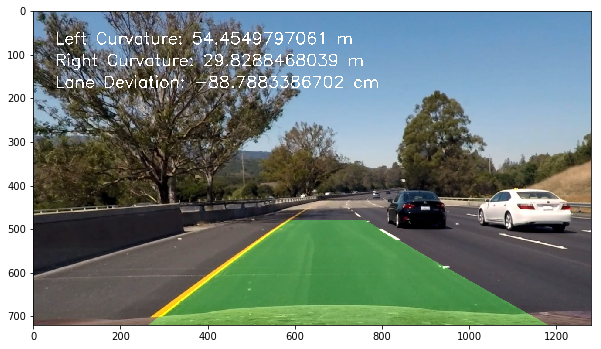

In [4]:
image = cv2.imread(image_file)
result = pipeline(image)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)

In [5]:
video_output = 'annotated.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline) 
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video annotated.mp4
[MoviePy] Writing video annotated.mp4


100%|█████████▉| 1260/1261 [11:25<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated.mp4 

CPU times: user 11min 2s, sys: 22.7 s, total: 11min 25s
Wall time: 11min 28s


In [6]:
window_width = 64 # 
window_height = 120 #180 con el primer src, 120
margin = 60 #40 con el primer src, 60

src = np.float32(
    [[0, 720],
    [1280, 720],
    [460, 490],
    [820, 490]])

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])


m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)

last_l_fit2 = np.zeros((3,), dtype=np.float64)
last_r_fit2 = np.zeros((3,), dtype=np.float64)
last_l_fit2_cr = np.zeros((3,), dtype=np.float64)
last_r_fit2_cr = np.zeros((3,), dtype=np.float64)
alfit = np.zeros((8,3,), dtype=np.float64)
arfit = np.zeros((8,3,), dtype=np.float64)
meanlfit = np.zeros((3,), dtype=np.float64)
meanrfit = np.zeros((3,), dtype=np.float64)
last_points = np.zeros((1,720*2,2), dtype=np.int32)
t = 0
n = 0

def pipeline2(image):
    global last_l_fit2
    global last_r_fit2
    global last_l_fit2_cr
    global last_r_fit2_cr
    global last_points
    global t
    global n
    image = cv2.undistort(image, mtx, dist, None, mtx)
    binary = combined_thresh2(image)
    warped = cv2.warpPerspective(binary, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warped[:,0:150] = 0
    warped[300:720,500:1000] = 0
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    left,right,template = window_search(warped,window_centroids)
    left_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(left, cv2.COLOR_BGR2GRAY))))
    right_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(right, cv2.COLOR_BGR2GRAY))))
    t = t + 1 
    n = (n + 1)%8
    if (len(left_points)>0):
        if(t>8):
            l_fit = np.polyfit(left_points[:,0],left_points[:,1],2)
            alfit[n] = l_fit
            meanlfit = np.mean(alfit,axis=0)
        else:
            meanlfit = np.polyfit(left_points[:,0],left_points[:,1],2)
    else:
        meanlfit = last_l_fit2
        
    if (len(right_points)>0):
        if(t>8):        
            r_fit = np.polyfit(right_points[:,0],right_points[:,1],2)
            arfit[n] = r_fit
            meanrfit = np.mean(arfit,axis=0)
        else:    
            meanrfit = np.polyfit(right_points[:,0],right_points[:,1],2)
    else:
        meanrfit = last_r_fit2
    
    the_points = np.zeros((1,720*2,2), dtype=np.int32)
    for i in range(0,720):
        the_points[0][i] = [int(meanlfit[0]*i*i + meanlfit[1]*i + meanlfit[2]),i]
    for i in range(0,720):
        the_points[0][i+720] = [int(meanrfit[0]*(719-i)*(719-i) + meanrfit[1]*(719-i) + meanrfit[2]),(719-i)]
    if(t>1):
        dist_lb = np.linalg.norm(the_points[0][719]-last_points[0][719])
        dist_rb = np.linalg.norm(the_points[0][720]-last_points[0][720])
        dist_lt = np.linalg.norm(the_points[0][0]-last_points[0][0])
        dist_rt = np.linalg.norm(the_points[0][2*720-1]-last_points[0][2*720-1])
        if((dist_lb>50)or(dist_rb>50)):
            the_points = last_points
            
    output_pol = np.zeros_like(template)
    cv2.fillConvexPoly(output_pol,the_points, (0,255,0))
    if (len(left_points)>0):
        left_fit_cr = np.polyfit(left_points[:,1]*ym_per_pix, left_points[:,0]*xm_per_pix, 2)
    else:
        left_fit_cr = last_l_fit2_cr
    if (len(right_points)>0): 
        right_fit_cr = np.polyfit(right_points[:,1]*ym_per_pix, right_points[:,0]*xm_per_pix, 2)
    else:
        right_fit_cr = last_r_fit2_cr
    left_curverad = ((1 + (2*left_fit_cr[0]*719*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*719*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_dev = (image.shape[1]/2-(meanlfit[2]+(meanrfit[2]-meanlfit[2])/2))*xm_per_pix*100
    newwarp = cv2.warpPerspective(output_pol, m_inv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result,'Left Curvature: '+str(left_curverad)+' m',(50,75), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    cv2.putText(result,'Right Curvature: '+str(right_curverad)+' m',(50,125), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    cv2.putText(result,'Lane Deviation: '+str(center_dev)+' cm',(50,175), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
    last_l_fit2_cr = left_fit_cr
    last_r_fit2_cr = right_fit_cr
    last_l_fit2 = meanlfit
    last_r_fit2 = meanrfit
    last_points = the_points
    return result

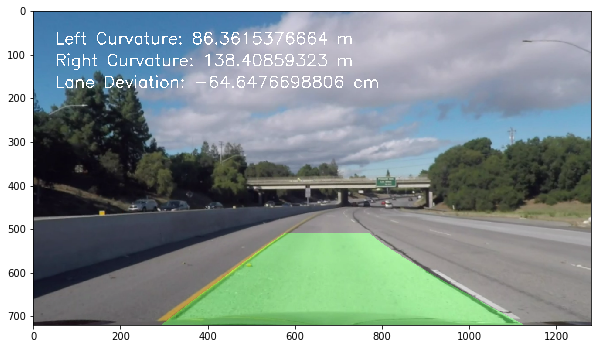

In [7]:
image_file = 'test_images/1.png'
image = cv2.imread(image_file)
image = cv2.resize(image, (1280, 720)) 
result = pipeline2(image)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)

In [8]:
video_output = 'challenge_annotated.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_annotated.mp4
[MoviePy] Writing video challenge_annotated.mp4


100%|██████████| 485/485 [04:42<00:00,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_annotated.mp4 

CPU times: user 4min 37s, sys: 7.84 s, total: 4min 45s
Wall time: 4min 45s


In [9]:
last_l_fit2 = np.zeros((3,), dtype=np.float64)
last_r_fit2 = np.zeros((3,), dtype=np.float64)
last_l_fit2_cr = np.zeros((3,), dtype=np.float64)
last_r_fit2_cr = np.zeros((3,), dtype=np.float64)
alfit = np.zeros((8,3,), dtype=np.float64)
arfit = np.zeros((8,3,), dtype=np.float64)
meanlfit = np.zeros((3,), dtype=np.float64)
meanrfit = np.zeros((3,), dtype=np.float64)
last_points = np.zeros((1,720*2,2), dtype=np.int32)
t = 0
n = 0
video_output = 'harder_annotated.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_annotated.mp4
[MoviePy] Writing video harder_annotated.mp4


100%|█████████▉| 1199/1200 [11:19<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_annotated.mp4 

CPU times: user 11min 17s, sys: 16.5 s, total: 11min 33s
Wall time: 11min 25s


In [10]:
last_l_fit2 = np.zeros((3,), dtype=np.float64)
last_r_fit2 = np.zeros((3,), dtype=np.float64)
last_l_fit2_cr = np.zeros((3,), dtype=np.float64)
last_r_fit2_cr = np.zeros((3,), dtype=np.float64)
alfit = np.zeros((8,3,), dtype=np.float64)
arfit = np.zeros((8,3,), dtype=np.float64)
meanlfit = np.zeros((3,), dtype=np.float64)
meanrfit = np.zeros((3,), dtype=np.float64)
last_points = np.zeros((1,720*2,2), dtype=np.int32)
t = 0
n = 0
src = np.float32(
    [[0, 720],
    [1280, 720],
    [510, 480],
    [770, 480]])

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])
m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)
video_output = 'annotated_v2.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video annotated_v2.mp4
[MoviePy] Writing video annotated_v2.mp4


100%|█████████▉| 1260/1261 [12:09<00:00,  1.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_v2.mp4 

CPU times: user 12min 20s, sys: 22.5 s, total: 12min 42s
Wall time: 12min 11s
